#For deleting 
import shutil
LOGS_DIR = BASE_PATH.joinpath("wandb")
if LOGS_DIR.exists():
    shutil.rmtree(LOGS_DIR)
print (str(LOGS_DIR.absolute()))

step2v3 = data augmentation - brightness, contrast and quality more adjusted not including masks

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import keras.backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras
import os
import cv2
import pathlib
import datetime
import wandb
from wandb.keras import WandbCallback
BASE_PATH = pathlib.Path(".")
os.environ['WANDB_API_KEY'] = 'local-f29e3da86585769dd70643a027ab5817d34b1b6a'  
os.environ['WANDB_BASE_URL'] = 'https://wandb.ikt-lab.internal.uia.no/'

PROJECT_NAME="FishTest_aug"

In [2]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: benteb13. Use `wandb login --relogin` to force relogin


True

In [3]:
dir0 = BASE_PATH.joinpath('Fish_Dataset/Fish_Dataset')
files =[]
paths = []
classes_paths = [x for x in list (dir0.glob("**/*")) if "GT" not in x.name and not x.name.startswith("_") and not x.name.startswith(".") and x.is_dir()]
for class_path in classes_paths:
    class_images = list(class_path.glob("*.png"))
    class_names = [x.name for x in class_images]
    files.extend(class_names)
    paths.extend([str(x.absolute()) for x in class_images])

In [4]:
dir1 = BASE_PATH.joinpath('Fish_Dataset/Fish_Dataset')
mfiles =[]
mpaths = []
classes_paths = [x for x in list (dir0.glob("**/*")) if "GT" in x.name and not x.name.startswith("_") and not x.name.startswith(".") and x.is_dir()]
for class_path in classes_paths:
    class_images = list(class_path.glob("*.png"))
    class_names = [x.name for x in class_images]
    mfiles.extend(class_names)
    mpaths.extend([str(x.absolute()) for x in class_images])

In [5]:
df0 = pd.DataFrame(columns = ['label','file','path','mpath'])
df0['label'] = 1
df0['file'] = files
df0['path'] = paths
df0['mpath'] = mpaths

display(df0)

,label,file,path,mpath
0,NaN,00751.png,/home/benteb13/Fish/Test/Fish_Dataset/Fish_Dat...,/home/benteb13/Fish/Test/Fish_Dataset/Fish_Dat...
1,NaN,00200.png,/home/benteb13/Fish/Test/Fish_Dataset/Fish_Dat...,/home/benteb13/Fish/Test/Fish_Dataset/Fish_Dat...
2,NaN,00553.png,/home/benteb13/Fish/Test/Fish_Dataset/Fish_Dat...,/home/benteb13/Fish/Test/Fish_Dataset/Fish_Dat...
3,NaN,00842.png,/home/benteb13/Fish/Test/Fish_Dataset/Fish_Dat...,/home/benteb13/Fish/Test/Fish_Dataset/Fish_Dat...
4,NaN,00064.png,/home/benteb13/Fish/Test/Fish_Dataset/Fish_Dat...,/home/benteb13/Fish/Test/Fish_Dataset/Fish_Dat...
...,...,...,...,...
8995,NaN,00520.png,/home/benteb13/Fish/Test/Fish_Dataset/Fish_Dat...,/home/benteb13/Fish/Test/Fish_Dataset/Fish_Dat...
8996,NaN,00796.png,/home/benteb13/Fish/Test/Fish_Dataset/Fish_Dat...,/home/benteb13/Fish/Test/Fish_Dataset/Fish_Dat...
8997,NaN,00026.png,/home/benteb13/Fish/Test/Fish_Dataset/Fish_Dat...,/home/benteb13/Fish/Test/Fish_Dataset/Fish_Dat...
8998,NaN,00963.png,/home/benteb13/Fish/Test/Fish_Dataset/Fish_Dat...,/home/benteb13/Fish/Test/Fish_Dataset/Fish_Dat...


(445, 590)


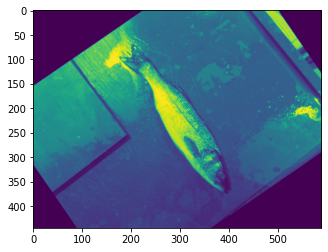

(445, 590)


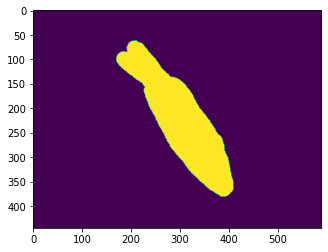

In [6]:
#Display image from dataset
path0=df0.loc[0,'path']
img0=cv2.imread(path0,cv2.IMREAD_GRAYSCALE)
shape0=img0.shape
print(shape0)
plt.imshow(img0)
plt.show()

#Display mask from dataset
path1=df0.loc[0,'mpath']
img1=cv2.imread(path1,cv2.IMREAD_GRAYSCALE)
shape1=img1.shape
print(shape1)
plt.imshow(img1)
plt.show()

#### Train/test data settings:

In [7]:
option_train = True
img_size = [256,256]
BATCH_SIZE = 16
BUFFER_SIZE = 1000
EPOCHS = 150
seed = (1, 2)

df = df0.iloc[0:(len(df0)//10)*3]
train_size = 0.6
validate_size = 0.2
train_df, valid_df, test_df = np.split(df.sample(frac=1), [int(train_size * len(df)), int((validate_size + train_size) * len(df))])

TRAIN_LENGTH = len(train_df)
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [8]:
def data_augmentation(fish_img, mask_img):
    if tf.random.uniform(()) > 0.5:
        fish_img = tf.image.flip_left_right(fish_img)
        mask_img = tf.image.flip_left_right(mask_img)
    return fish_img, mask_img

def random_bright(fish_img, mask_img):
    fish_img = tf.image.stateless_random_brightness(fish_img, 0.4, seed)
    #mask_img = tf.image.stateless_random_brightness(mask_img, 0.2, seed)   
    return fish_img, mask_img

def random_contrast(fish_img, mask_img):
    fish_img = tf.image.stateless_random_contrast(fish_img, 0.1, 0.5, seed)
    #mask_img = tf.image.stateless_random_contrast(mask_img, 0.2, 0.5,  seed)   
    return fish_img, mask_img

def random_quality(fish_img, mask_img):
    fish_img = tf.image.stateless_random_jpeg_quality(fish_img, 55, 100, seed)
    #mask_img = tf.image.stateless_random_jpeg_quality(mask_img, 75, 100, seed)
    return fish_img, mask_img

def preprocessing(fish_path, mask_path):
    fish_img = tf.io.read_file(fish_path) 
    fish_img = tf.image.decode_jpeg(fish_img, channels=3)
    fish_img = tf.image.resize(fish_img, img_size)
    fish_img = tf.cast(fish_img, tf.float32) / 255.0
    
    mask_img = tf.io.read_file(mask_path)
    mask_img = tf.image.decode_jpeg(mask_img, channels=3)
    mask_img = tf.image.resize(mask_img, img_size)
    mask_img = mask_img[:,:,:1]    
    mask_img = tf.math.sign(mask_img)    
    return fish_img, mask_img

def create_dataset(df, train = False):
    if not train:
        ds = tf.data.Dataset.from_tensor_slices((df["path"].values, df["mpath"].values))
        ds = ds.map(preprocessing, tf.data.AUTOTUNE)
    else:
        ds = tf.data.Dataset.from_tensor_slices((df["path"].values, df["mpath"].values))
        ds = ds.map(preprocessing, tf.data.AUTOTUNE)
        ds = ds.map(data_augmentation, tf.data.AUTOTUNE)           
        ds = ds.map(random_bright, tf.data.AUTOTUNE)
        ds = ds.map(random_contrast, tf.data.AUTOTUNE)
        ds = ds.map(random_quality, tf.data.AUTOTUNE)
    return ds

In [9]:
train = create_dataset(train_df, train = True)
valid = create_dataset(valid_df)
test = create_dataset(test_df)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = valid.batch(BATCH_SIZE)
test_dataset = test.batch(BATCH_SIZE)

2023-02-13 10:08:31.286266: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30996 MB memory:  -> device: 0, name: Tesla V100-SXM3-32GB, pci bus id: 0000:5e:00.0, compute capability: 7.0


#### MobileNetV2 Model

In [10]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[256,256,3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
    ]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

In [11]:
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)    
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

    if norm_type.lower() == 'batchnorm':
        result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
        result.add(InstanceNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
        result.add(tf.keras.layers.ReLU())
    return result

up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
    ]

In [12]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[256,256,3])

  # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

  # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2, activation='sigmoid',
      padding='same')  #64x64 -> 128x128
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

#### Train the model

In [13]:
def dice(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(in_gt, in_pred):
    return 1 - dice(in_gt, in_pred)

def iou(y_true, y_pred):
    y_true = tf.keras.backend.flatten(y_true)
    y_pred = tf.keras.backend.flatten(y_pred)
    y_true_f = tf.cast(y_true, tf.float32)
    y_pred_f = tf.cast(y_pred, tf.float32)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + 1e-7) / (union + 1e-7)

def iou_loss(y_true, y_pred):
    return 1.0 - iou(y_true, y_pred)

In [14]:
def visualize(display_list):
    plt.figure(figsize=(12,12))
    title = ['Input Image', 'Predicted Mask', 'True Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def show_predictions(model, sample_image, sample_mask):
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    pred_mask = pred_mask.reshape(img_size[0],img_size[1],1)
    visualize([sample_image, pred_mask, sample_mask])

In [15]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if (epoch + 1) % 3 == 0:
            show_predictions(sample_image, sample_mask)
            
model_config = dict(
    unet_model_iou = [lambda *args: unet_model(*args), [iou_loss], [iou, "binary_accuracy"], "adam" , 1],
    unet_model_dice = [lambda *args: unet_model(*args), [dice_loss], [dice, "binary_accuracy"], "adam" , 1]
)

for model_name, (model_fn, model_loss, model_metrics, model_loss_fn, batch_size) in model_config.items():
    experiment_name = f"{model_name}_{str(datetime.datetime.now())}"
    experiment_path = pathlib.Path(f"./logs/{experiment_name}")
    checkpoint_name = f"{model_name}"
    checkpoint_path = pathlib.Path(f"./checkpoints/{checkpoint_name}")
    model = model_fn(1)
    model.compile(optimizer= model_loss_fn,
                  loss = model_loss,
                  metrics= model_metrics)            
    if option_train:
        run = wandb.init(reinit = True , name = experiment_name , project = PROJECT_NAME, config = {
                  #"learning_rate": 0.001,
                  "epochs": EPOCHS ,
                  "batch_size": batch_size,
                  "optimizer" : model_loss_fn
        })        
        model_history = model.fit(train_dataset, epochs=EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              batch_size = batch_size, 
                              validation_data=valid_dataset,
                              callbacks=[
                                  #DisplayCallback(),
                                  WandbCallback(),
                                  tf.keras.callbacks.TensorBoard(log_dir=experiment_path,
                                                                 histogram_freq=0,
                                                                 write_graph=True,
                                                                 write_images=True),
                                  tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                                 save_weights_only=True,
                                                                 monitor="val_loss",
                                                                 save_best_only=True,
                                                                 mode='auto')                              
                              ])
        run.finish()

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.
2023-02-13 10:08:49.864929: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2023-02-13 10:08:49.865008: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2023-02-13 10:08:49.865113: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1630] Profiler found 1 GPUs
2023-02-13 10:08:50.061844: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.
2023-02-13 10:08:50.062118: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1765] CUPTI activity buffer flushed
/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom 

Epoch 1/150


2023-02-13 10:08:57.531325: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


  1/101 [..............................] - ETA: 15:52 - loss: 0.8359 - iou: 0.1641 - binary_accuracy: 0.5267

2023-02-13 10:08:59.903391: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2023-02-13 10:08:59.903429: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.


  2/101 [..............................] - ETA: 2:06 - loss: 0.8158 - iou: 0.1842 - binary_accuracy: 0.5001 

2023-02-13 10:09:01.090713: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-02-13 10:09:01.091408: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1765] CUPTI activity buffer flushed
2023-02-13 10:09:01.175831: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:526]  GpuTracer has collected 5183 callback api events and 3710 activity events. 
2023-02-13 10:09:01.229621: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.
2023-02-13 10:09:01.301720: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/unet_model_iou_2023-02-13 10:08:42.358645/train/plugins/profile/2023_02_13_10_09_01

2023-02-13 10:09:01.348906: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/unet_model_iou_2023-02-13 10:08:42.358645/train/plugins/profile/2023_02_13_10_09_01/jupyter-benteb13.trace.json.gz
2023-02-13 10:09:01.404440: I te

101/101 [==============================] - 17s 79ms/step - loss: 0.2703 - iou: 0.7297 - binary_accuracy: 0.9320 - val_loss: 0.2218 - val_iou: 0.7783 - val_binary_accuracy: 0.9538


2023-02-13 10:09:14.323857: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/benteb13/Fish/Test/wandb/run-20230213_100842-10zm4y5m/files/model-best/assets


/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/home/benteb13/Fish/Test/wandb/run-20230213_100842-10zm4y5m/files/model-best)... Done. 0.3s


Epoch 2/150
101/101 [==============================] - 6s 54ms/step - loss: 0.1442 - iou: 0.8557 - binary_accuracy: 0.9745 - val_loss: 0.1317 - val_iou: 0.8683 - val_binary_accuracy: 0.9752
INFO:tensorflow:Assets written to: /home/benteb13/Fish/Test/wandb/run-20230213_100842-10zm4y5m/files/model-best/assets


/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/home/benteb13/Fish/Test/wandb/run-20230213_100842-10zm4y5m/files/model-best)... Done. 0.3s


Epoch 3/150
101/101 [==============================] - 5s 52ms/step - loss: 0.1333 - iou: 0.8669 - binary_accuracy: 0.9760 - val_loss: 0.1287 - val_iou: 0.8713 - val_binary_accuracy: 0.9754
INFO:tensorflow:Assets written to: /home/benteb13/Fish/Test/wandb/run-20230213_100842-10zm4y5m/files/model-best/assets


/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/home/benteb13/Fish/Test/wandb/run-20230213_100842-10zm4y5m/files/model-best)... Done. 0.3s


Epoch 4/150
101/101 [==============================] - 5s 54ms/step - loss: 0.1245 - iou: 0.8757 - binary_accuracy: 0.9772 - val_loss: 0.1270 - val_iou: 0.8731 - val_binary_accuracy: 0.9755
INFO:tensorflow:Assets written to: /home/benteb13/Fish/Test/wandb/run-20230213_100842-10zm4y5m/files/model-best/assets


/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/home/benteb13/Fish/Test/wandb/run-20230213_100842-10zm4y5m/files/model-best)... Done. 0.3s


Epoch 5/150
101/101 [==============================] - 5s 53ms/step - loss: 0.1220 - iou: 0.8781 - binary_accuracy: 0.9775 - val_loss: 0.1295 - val_iou: 0.8706 - val_binary_accuracy: 0.9749
Epoch 6/150
101/101 [==============================] - 5s 52ms/step - loss: 0.1193 - iou: 0.8808 - binary_accuracy: 0.9779 - val_loss: 0.1287 - val_iou: 0.8713 - val_binary_accuracy: 0.9754
Epoch 7/150
101/101 [==============================] - 5s 53ms/step - loss: 0.1157 - iou: 0.8841 - binary_accuracy: 0.9786 - val_loss: 0.1234 - val_iou: 0.8767 - val_binary_accuracy: 0.9762
INFO:tensorflow:Assets written to: /home/benteb13/Fish/Test/wandb/run-20230213_100842-10zm4y5m/files/model-best/assets


/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/home/benteb13/Fish/Test/wandb/run-20230213_100842-10zm4y5m/files/model-best)... Done. 0.3s


Epoch 8/150
101/101 [==============================] - 5s 52ms/step - loss: 0.1161 - iou: 0.8841 - binary_accuracy: 0.9783 - val_loss: 0.1247 - val_iou: 0.8754 - val_binary_accuracy: 0.9759
Epoch 9/150
101/101 [==============================] - 5s 53ms/step - loss: 0.1143 - iou: 0.8860 - binary_accuracy: 0.9786 - val_loss: 0.1220 - val_iou: 0.8781 - val_binary_accuracy: 0.9759
INFO:tensorflow:Assets written to: /home/benteb13/Fish/Test/wandb/run-20230213_100842-10zm4y5m/files/model-best/assets


/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/home/benteb13/Fish/Test/wandb/run-20230213_100842-10zm4y5m/files/model-best)... Done. 0.3s


Epoch 10/150
101/101 [==============================] - 5s 52ms/step - loss: 0.1101 - iou: 0.8892 - binary_accuracy: 0.9795 - val_loss: 0.1211 - val_iou: 0.8790 - val_binary_accuracy: 0.9760
INFO:tensorflow:Assets written to: /home/benteb13/Fish/Test/wandb/run-20230213_100842-10zm4y5m/files/model-best/assets


/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/home/benteb13/Fish/Test/wandb/run-20230213_100842-10zm4y5m/files/model-best)... Done. 0.3s


Epoch 11/150
101/101 [==============================] - 5s 52ms/step - loss: 0.1124 - iou: 0.8877 - binary_accuracy: 0.9788 - val_loss: 0.1211 - val_iou: 0.8790 - val_binary_accuracy: 0.9763
INFO:tensorflow:Assets written to: /home/benteb13/Fish/Test/wandb/run-20230213_100842-10zm4y5m/files/model-best/assets


/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/home/benteb13/Fish/Test/wandb/run-20230213_100842-10zm4y5m/files/model-best)... Done. 0.3s


Epoch 12/150
101/101 [==============================] - 5s 52ms/step - loss: 0.1098 - iou: 0.8900 - binary_accuracy: 0.9794 - val_loss: 0.1251 - val_iou: 0.8749 - val_binary_accuracy: 0.9758
Epoch 13/150
101/101 [==============================] - 5s 51ms/step - loss: 0.1083 - iou: 0.8915 - binary_accuracy: 0.9796 - val_loss: 0.1215 - val_iou: 0.8785 - val_binary_accuracy: 0.9762
Epoch 14/150
101/101 [==============================] - 5s 51ms/step - loss: 0.1091 - iou: 0.8898 - binary_accuracy: 0.9793 - val_loss: 0.1346 - val_iou: 0.8653 - val_binary_accuracy: 0.9740
Epoch 15/150
101/101 [==============================] - 5s 52ms/step - loss: 0.1082 - iou: 0.8918 - binary_accuracy: 0.9796 - val_loss: 0.1329 - val_iou: 0.8671 - val_binary_accuracy: 0.9744
Epoch 16/150
101/101 [==============================] - 5s 53ms/step - loss: 0.1042 - iou: 0.8959 - binary_accuracy: 0.9804 - val_loss: 0.1240 - val_iou: 0.8761 - val_binary_accuracy: 0.9757
Epoch 17/150
101/101 [=======================

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/home/benteb13/Fish/Test/wandb/run-20230213_100842-10zm4y5m/files/model-best)... Done. 0.3s


Epoch 20/150
101/101 [==============================] - 5s 53ms/step - loss: 0.1061 - iou: 0.8942 - binary_accuracy: 0.9800 - val_loss: 0.1255 - val_iou: 0.8746 - val_binary_accuracy: 0.9747
Epoch 21/150
101/101 [==============================] - 5s 53ms/step - loss: 0.1039 - iou: 0.8964 - binary_accuracy: 0.9802 - val_loss: 0.1282 - val_iou: 0.8719 - val_binary_accuracy: 0.9741
Epoch 22/150
101/101 [==============================] - 5s 53ms/step - loss: 0.1038 - iou: 0.8963 - binary_accuracy: 0.9804 - val_loss: 0.1213 - val_iou: 0.8787 - val_binary_accuracy: 0.9762
Epoch 23/150
101/101 [==============================] - 5s 54ms/step - loss: 0.1018 - iou: 0.8975 - binary_accuracy: 0.9806 - val_loss: 0.1213 - val_iou: 0.8788 - val_binary_accuracy: 0.9761
Epoch 24/150
101/101 [==============================] - 5s 52ms/step - loss: 0.1030 - iou: 0.8972 - binary_accuracy: 0.9805 - val_loss: 0.1204 - val_iou: 0.8797 - val_binary_accuracy: 0.9764
Epoch 25/150
101/101 [=======================

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/home/benteb13/Fish/Test/wandb/run-20230213_100842-10zm4y5m/files/model-best)... Done. 0.3s


Epoch 26/150
101/101 [==============================] - 5s 54ms/step - loss: 0.1028 - iou: 0.8974 - binary_accuracy: 0.9805 - val_loss: 0.1232 - val_iou: 0.8768 - val_binary_accuracy: 0.9759
Epoch 27/150
101/101 [==============================] - 5s 54ms/step - loss: 0.1000 - iou: 0.9001 - binary_accuracy: 0.9811 - val_loss: 0.1268 - val_iou: 0.8733 - val_binary_accuracy: 0.9743
Epoch 28/150
101/101 [==============================] - 5s 52ms/step - loss: 0.1021 - iou: 0.8979 - binary_accuracy: 0.9807 - val_loss: 0.1265 - val_iou: 0.8735 - val_binary_accuracy: 0.9752
Epoch 29/150
101/101 [==============================] - 5s 53ms/step - loss: 0.0997 - iou: 0.9005 - binary_accuracy: 0.9809 - val_loss: 0.1264 - val_iou: 0.8736 - val_binary_accuracy: 0.9752
Epoch 30/150
101/101 [==============================] - 5s 52ms/step - loss: 0.1020 - iou: 0.8981 - binary_accuracy: 0.9808 - val_loss: 0.1237 - val_iou: 0.8764 - val_binary_accuracy: 0.9754
Epoch 31/150
101/101 [=======================

binary_accuracy,▁▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▆▇▆▇▇▇▇▇▇▇▇███▇▇████▇█
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
iou,▁▃▄▅▆▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
loss,█▆▅▄▃▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_binary_accuracy,▆▆▇▇▇▅█▆▇▇▆▆▆▆▆▅▅▆▅▅▅▅▂▅▅▄▄▂▃▄▄▃▃▂▂▃▃▃▂▁
val_iou,▃▅▆▆▆▆█▅▇▆▆▆▆▅▆▅▅▆▆▄▅▄▂▄▅▄▄▂▃▄▄▃▃▁▁▂▃▂▁▁
val_loss,▆▄▃▃▃▃▁▄▂▃▃▃▃▄▃▄▄▃▃▅▄▅▇▅▄▅▅▇▆▅▅▆▆██▇▇▇██
best_epoch,24
best_val_loss,0.11923
binary_accuracy,0.98418
epoch,149


2023-02-13 10:25:56.804586: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2023-02-13 10:25:56.804639: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2023-02-13 10:25:57.625088: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.
2023-02-13 10:25:57.625307: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1765] CUPTI activity buffer flushed


Epoch 1/150
  1/101 [..............................] - ETA: 3:57 - loss: 0.6961 - dice: 0.3039 - binary_accuracy: 0.4108

2023-02-13 10:26:00.368164: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2023-02-13 10:26:00.368205: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.


  2/101 [..............................] - ETA: 56s - loss: 0.6921 - dice: 0.3079 - binary_accuracy: 0.4237 

2023-02-13 10:26:01.066853: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-02-13 10:26:01.067500: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1765] CUPTI activity buffer flushed
2023-02-13 10:26:01.208557: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:526]  GpuTracer has collected 408 callback api events and 406 activity events. 
2023-02-13 10:26:01.228465: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.
2023-02-13 10:26:01.241784: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/unet_model_dice_2023-02-13 10:25:51.320307/train/plugins/profile/2023_02_13_10_26_01

2023-02-13 10:26:01.249061: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/unet_model_dice_2023-02-13 10:25:51.320307/train/plugins/profile/2023_02_13_10_26_01/jupyter-benteb13.trace.json.gz


  5/101 [>.............................] - ETA: 27s - loss: 0.6454 - dice: 0.3546 - binary_accuracy: 0.5181WARNING:tensorflow:Callback method `on_train_batch_begin` is slow compared to the batch time (batch time: 0.0278s vs `on_train_batch_begin` time: 0.0719s). Check your callbacks.


2023-02-13 10:26:01.281638: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/unet_model_dice_2023-02-13 10:25:51.320307/train/plugins/profile/2023_02_13_10_26_01

2023-02-13 10:26:01.286777: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/unet_model_dice_2023-02-13 10:25:51.320307/train/plugins/profile/2023_02_13_10_26_01/jupyter-benteb13.memory_profile.json.gz
2023-02-13 10:26:01.287819: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: logs/unet_model_dice_2023-02-13 10:25:51.320307/train/plugins/profile/2023_02_13_10_26_01
Dumped tool data for xplane.pb to logs/unet_model_dice_2023-02-13 10:25:51.320307/train/plugins/profile/2023_02_13_10_26_01/jupyter-benteb13.xplane.pb
Dumped tool data for overview_page.pb to logs/unet_model_dice_2023-02-13 10:25:51.320307/train/plugins/profile/2023_02_13_10_26_01/jupyter-benteb13.overview_page.pb
Dumped tool da

101/101 [==============================] - 9s 69ms/step - loss: 0.1614 - dice: 0.8386 - binary_accuracy: 0.9410 - val_loss: 0.0917 - val_dice: 0.9084 - val_binary_accuracy: 0.9736
INFO:tensorflow:Assets written to: /home/benteb13/Fish/Test/wandb/run-20230213_102551-fmde6vb6/files/model-best/assets


/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/home/benteb13/Fish/Test/wandb/run-20230213_102551-fmde6vb6/files/model-best)... Done. 0.3s


Epoch 2/150
101/101 [==============================] - 5s 54ms/step - loss: 0.0679 - dice: 0.9322 - binary_accuracy: 0.9817 - val_loss: 0.0836 - val_dice: 0.9165 - val_binary_accuracy: 0.9738
INFO:tensorflow:Assets written to: /home/benteb13/Fish/Test/wandb/run-20230213_102551-fmde6vb6/files/model-best/assets


/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/home/benteb13/Fish/Test/wandb/run-20230213_102551-fmde6vb6/files/model-best)... Done. 0.3s


Epoch 3/150
101/101 [==============================] - 5s 54ms/step - loss: 0.0611 - dice: 0.9390 - binary_accuracy: 0.9825 - val_loss: 0.0819 - val_dice: 0.9181 - val_binary_accuracy: 0.9733
INFO:tensorflow:Assets written to: /home/benteb13/Fish/Test/wandb/run-20230213_102551-fmde6vb6/files/model-best/assets


/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/home/benteb13/Fish/Test/wandb/run-20230213_102551-fmde6vb6/files/model-best)... Done. 0.3s


Epoch 4/150
101/101 [==============================] - 6s 55ms/step - loss: 0.0586 - dice: 0.9415 - binary_accuracy: 0.9827 - val_loss: 0.0801 - val_dice: 0.9200 - val_binary_accuracy: 0.9732
INFO:tensorflow:Assets written to: /home/benteb13/Fish/Test/wandb/run-20230213_102551-fmde6vb6/files/model-best/assets


/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/home/benteb13/Fish/Test/wandb/run-20230213_102551-fmde6vb6/files/model-best)... Done. 0.4s


Epoch 5/150
101/101 [==============================] - 6s 55ms/step - loss: 0.0570 - dice: 0.9429 - binary_accuracy: 0.9827 - val_loss: 0.0798 - val_dice: 0.9203 - val_binary_accuracy: 0.9731
INFO:tensorflow:Assets written to: /home/benteb13/Fish/Test/wandb/run-20230213_102551-fmde6vb6/files/model-best/assets


/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/home/benteb13/Fish/Test/wandb/run-20230213_102551-fmde6vb6/files/model-best)... Done. 0.3s


Epoch 6/150
101/101 [==============================] - 5s 54ms/step - loss: 0.0553 - dice: 0.9446 - binary_accuracy: 0.9831 - val_loss: 0.0803 - val_dice: 0.9197 - val_binary_accuracy: 0.9723
Epoch 7/150
101/101 [==============================] - 5s 54ms/step - loss: 0.0552 - dice: 0.9443 - binary_accuracy: 0.9828 - val_loss: 0.0786 - val_dice: 0.9215 - val_binary_accuracy: 0.9733
INFO:tensorflow:Assets written to: /home/benteb13/Fish/Test/wandb/run-20230213_102551-fmde6vb6/files/model-best/assets


/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/home/benteb13/Fish/Test/wandb/run-20230213_102551-fmde6vb6/files/model-best)... Done. 0.3s


Epoch 8/150
101/101 [==============================] - 6s 55ms/step - loss: 0.0531 - dice: 0.9470 - binary_accuracy: 0.9833 - val_loss: 0.0814 - val_dice: 0.9187 - val_binary_accuracy: 0.9715
Epoch 9/150
101/101 [==============================] - 6s 55ms/step - loss: 0.0520 - dice: 0.9481 - binary_accuracy: 0.9836 - val_loss: 0.0793 - val_dice: 0.9208 - val_binary_accuracy: 0.9721
Epoch 10/150
101/101 [==============================] - 5s 53ms/step - loss: 0.0515 - dice: 0.9486 - binary_accuracy: 0.9836 - val_loss: 0.0783 - val_dice: 0.9217 - val_binary_accuracy: 0.9729
INFO:tensorflow:Assets written to: /home/benteb13/Fish/Test/wandb/run-20230213_102551-fmde6vb6/files/model-best/assets


/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/home/benteb13/Fish/Test/wandb/run-20230213_102551-fmde6vb6/files/model-best)... Done. 0.3s


Epoch 11/150
101/101 [==============================] - 6s 56ms/step - loss: 0.0524 - dice: 0.9476 - binary_accuracy: 0.9832 - val_loss: 0.0796 - val_dice: 0.9205 - val_binary_accuracy: 0.9721
Epoch 12/150
101/101 [==============================] - 5s 54ms/step - loss: 0.0509 - dice: 0.9490 - binary_accuracy: 0.9836 - val_loss: 0.0796 - val_dice: 0.9204 - val_binary_accuracy: 0.9723
Epoch 13/150
101/101 [==============================] - 5s 53ms/step - loss: 0.0505 - dice: 0.9494 - binary_accuracy: 0.9837 - val_loss: 0.0785 - val_dice: 0.9216 - val_binary_accuracy: 0.9721
Epoch 14/150
101/101 [==============================] - 5s 52ms/step - loss: 0.0507 - dice: 0.9489 - binary_accuracy: 0.9835 - val_loss: 0.0783 - val_dice: 0.9218 - val_binary_accuracy: 0.9726
INFO:tensorflow:Assets written to: /home/benteb13/Fish/Test/wandb/run-20230213_102551-fmde6vb6/files/model-best/assets


/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/home/benteb13/Fish/Test/wandb/run-20230213_102551-fmde6vb6/files/model-best)... Done. 0.3s


Epoch 15/150
101/101 [==============================] - 5s 54ms/step - loss: 0.0505 - dice: 0.9496 - binary_accuracy: 0.9835 - val_loss: 0.0796 - val_dice: 0.9205 - val_binary_accuracy: 0.9721
Epoch 16/150
101/101 [==============================] - 6s 55ms/step - loss: 0.0498 - dice: 0.9502 - binary_accuracy: 0.9837 - val_loss: 0.0799 - val_dice: 0.9202 - val_binary_accuracy: 0.9715
Epoch 17/150
101/101 [==============================] - 5s 53ms/step - loss: 0.0499 - dice: 0.9496 - binary_accuracy: 0.9837 - val_loss: 0.0803 - val_dice: 0.9198 - val_binary_accuracy: 0.9721
Epoch 18/150
101/101 [==============================] - 5s 54ms/step - loss: 0.0487 - dice: 0.9514 - binary_accuracy: 0.9840 - val_loss: 0.0812 - val_dice: 0.9189 - val_binary_accuracy: 0.9710
Epoch 19/150
101/101 [==============================] - 5s 52ms/step - loss: 0.0496 - dice: 0.9506 - binary_accuracy: 0.9836 - val_loss: 0.0783 - val_dice: 0.9218 - val_binary_accuracy: 0.9723
Epoch 20/150
101/101 [=============

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
wandb: Adding directory to artifact (/home/benteb13/Fish/Test/wandb/run-20230213_102551-fmde6vb6/files/model-best)... Done. 0.3s


Epoch 26/150
101/101 [==============================] - 6s 55ms/step - loss: 0.0491 - dice: 0.9510 - binary_accuracy: 0.9836 - val_loss: 0.0798 - val_dice: 0.9203 - val_binary_accuracy: 0.9717
Epoch 27/150
101/101 [==============================] - 5s 53ms/step - loss: 0.0473 - dice: 0.9526 - binary_accuracy: 0.9842 - val_loss: 0.0784 - val_dice: 0.9216 - val_binary_accuracy: 0.9719
Epoch 28/150
101/101 [==============================] - 5s 54ms/step - loss: 0.0480 - dice: 0.9520 - binary_accuracy: 0.9839 - val_loss: 0.0795 - val_dice: 0.9206 - val_binary_accuracy: 0.9719
Epoch 29/150
101/101 [==============================] - 5s 52ms/step - loss: 0.0474 - dice: 0.9527 - binary_accuracy: 0.9840 - val_loss: 0.0799 - val_dice: 0.9202 - val_binary_accuracy: 0.9716
Epoch 30/150
101/101 [==============================] - 5s 53ms/step - loss: 0.0462 - dice: 0.9538 - binary_accuracy: 0.9844 - val_loss: 0.0798 - val_dice: 0.9203 - val_binary_accuracy: 0.9715
Epoch 31/150
101/101 [=============

binary_accuracy,▁▃▃▄▄▄▅▄▄▅▅▅▅▆▅▆▆▆▆▅▆▆▆▆▇▆▆▇▆▇▆▆▇▇▇▇█▇█▇
dice,▁▃▅▅▅▆▆▆▅▆▆▆▆▇▆▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇██▇█▇██
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▄▄▄▃▃▃▄▃▃▃▃▂▃▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁
val_binary_accuracy,█▇▄▅▄▅▅▅▄▄▂▅▅▂▃▅▄▄▃▁▄▄▂▃▄▂▃▃▃▃▃▃▂▃▂▂▃▃▂▁
val_dice,▁▅▄▆▆▇▇▆▆▆▄▇▇▃▅█▅▆▅▂▇▅▄▄▆▄▄▄▅▄▄▄▄▄▃▃▅▃▃▁
val_loss,█▄▅▃▃▂▂▃▃▃▅▂▂▆▄▁▄▃▄▇▂▄▅▅▃▅▅▅▄▅▅▅▅▅▆▆▄▆▆█
best_epoch,24
best_val_loss,0.0778
binary_accuracy,0.9856
dice,0.95889


In [17]:
model.load_weights(checkpoint_path)

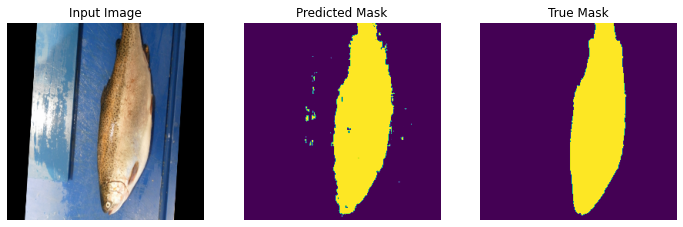

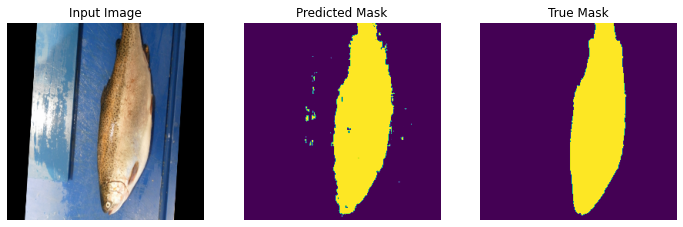

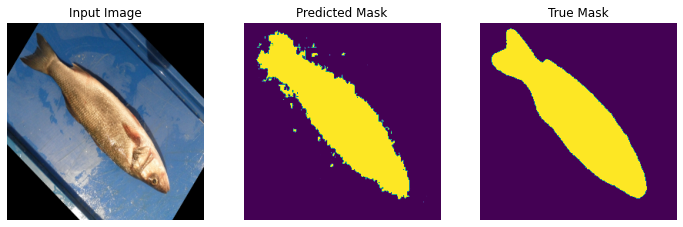

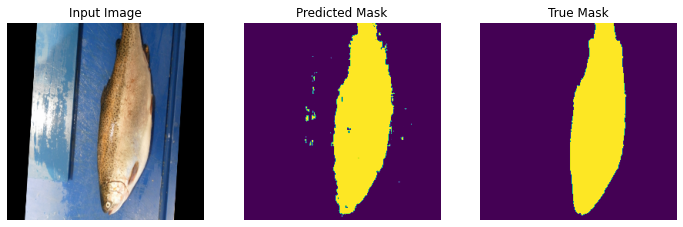

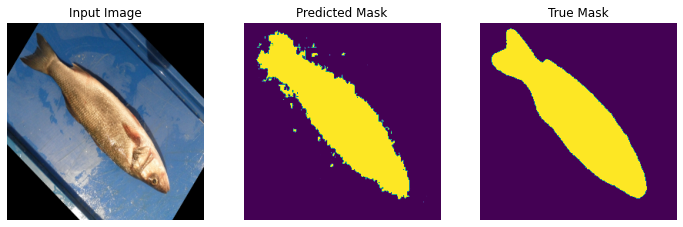

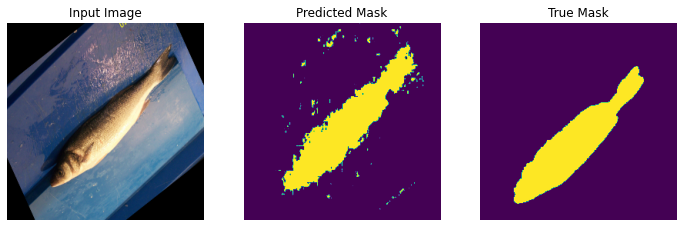

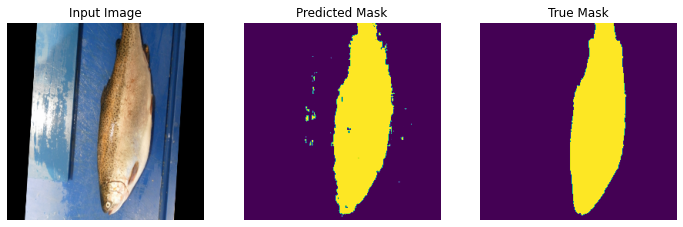

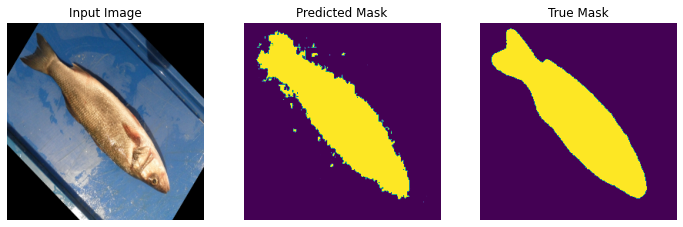

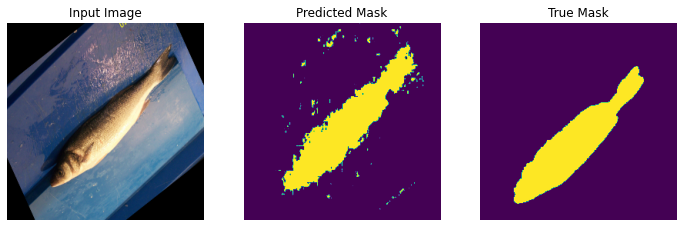

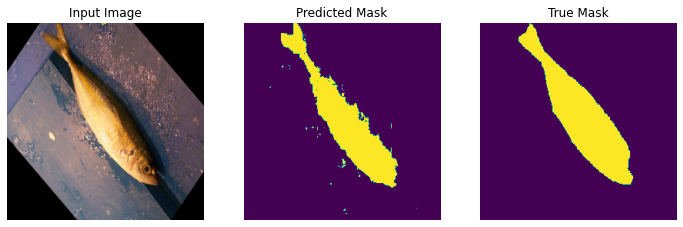

In [16]:
#Show sample images in test dataset with their true mask and predicted mask after training
for i in range(5):
    for images, masks in test_dataset.take(i):
        for img, mask in zip(images, masks):
            tsample_image = img
            tsample_mask = mask
            show_predictions(model, tsample_image, tsample_mask)
            break

# Step 2

Use pre-trained model to predict fish in the wild

In [17]:
nor_fish_path = BASE_PATH.joinpath('Fish_Dataset/Norsk_Fisk')

nf_files =[]
nf_paths = []
nf_classes_paths = [x for x in list (nor_fish_path.glob("**/*")) if not x.name.startswith("_") and not x.name.startswith(".") and x.is_dir()]
for nf_class_path in nf_classes_paths:
    nf_class_images = list(nf_class_path.glob("*.PNG"))
    nf_class_names = [x.name for x in nf_class_images]
    nf_files.extend(nf_class_names)
    nf_paths.extend([str(x.absolute()) for x in nf_class_images])    

In [18]:
nf_df = pd.DataFrame()
nf_df['label'] = 1
nf_df['file'] = nf_files
nf_df['path'] = nf_paths
nf_df['mpath'] = nf_paths

display(nf_df)

,label,file,path,mpath
0,NaN,128.PNG,/home/benteb13/Fish/Test/Fish_Dataset/Norsk_Fi...,/home/benteb13/Fish/Test/Fish_Dataset/Norsk_Fi...
1,NaN,13.PNG,/home/benteb13/Fish/Test/Fish_Dataset/Norsk_Fi...,/home/benteb13/Fish/Test/Fish_Dataset/Norsk_Fi...
2,NaN,185.PNG,/home/benteb13/Fish/Test/Fish_Dataset/Norsk_Fi...,/home/benteb13/Fish/Test/Fish_Dataset/Norsk_Fi...
3,NaN,50.PNG,/home/benteb13/Fish/Test/Fish_Dataset/Norsk_Fi...,/home/benteb13/Fish/Test/Fish_Dataset/Norsk_Fi...
4,NaN,99.PNG,/home/benteb13/Fish/Test/Fish_Dataset/Norsk_Fi...,/home/benteb13/Fish/Test/Fish_Dataset/Norsk_Fi...
...,...,...,...,...
1304,NaN,4-11.PNG,/home/benteb13/Fish/Test/Fish_Dataset/Norsk_Fi...,/home/benteb13/Fish/Test/Fish_Dataset/Norsk_Fi...
1305,NaN,4-21.PNG,/home/benteb13/Fish/Test/Fish_Dataset/Norsk_Fi...,/home/benteb13/Fish/Test/Fish_Dataset/Norsk_Fi...
1306,NaN,4-8.PNG,/home/benteb13/Fish/Test/Fish_Dataset/Norsk_Fi...,/home/benteb13/Fish/Test/Fish_Dataset/Norsk_Fi...
1307,NaN,4-17.PNG,/home/benteb13/Fish/Test/Fish_Dataset/Norsk_Fi...,/home/benteb13/Fish/Test/Fish_Dataset/Norsk_Fi...


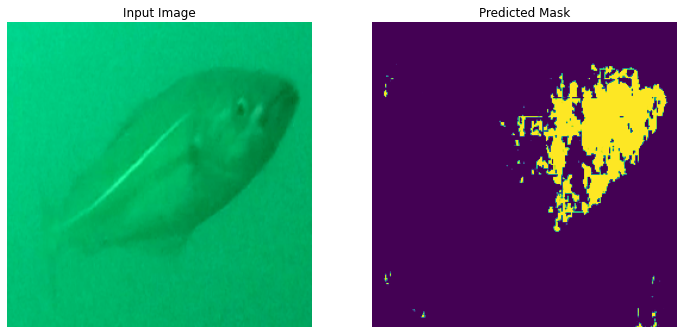

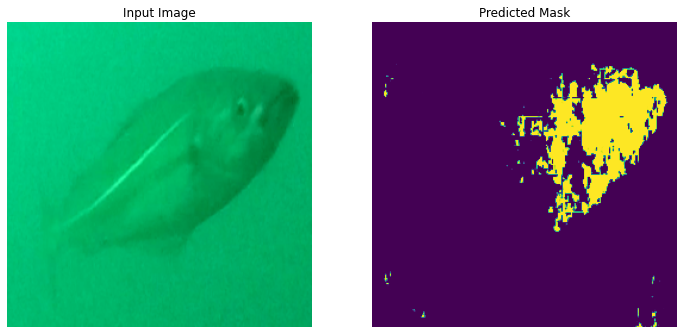

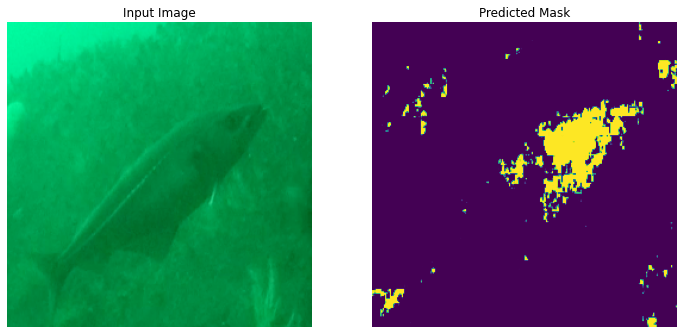

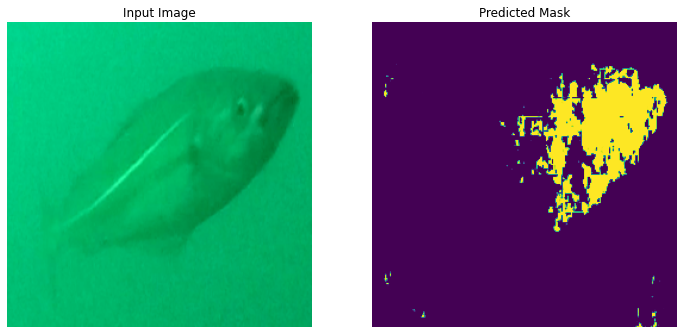

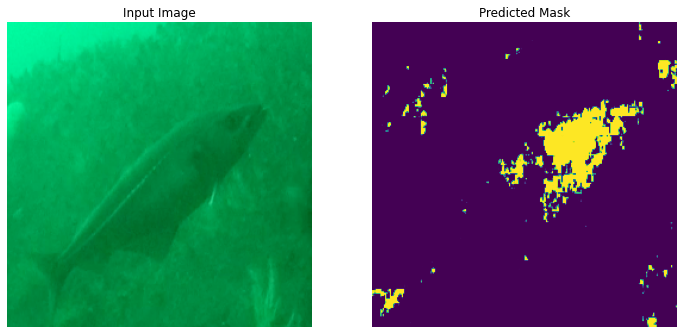

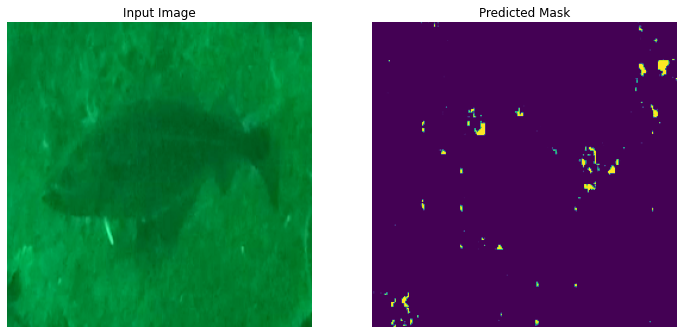

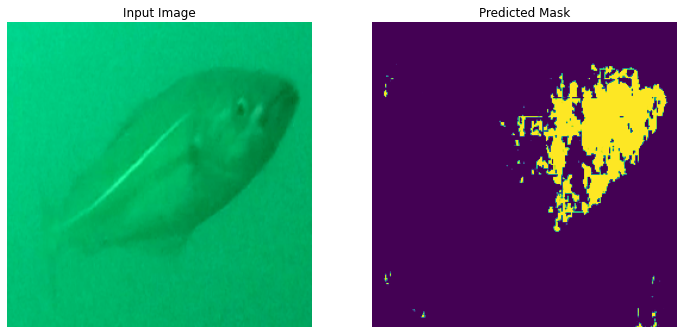

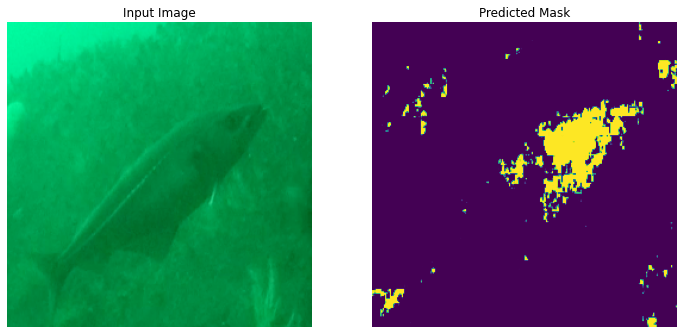

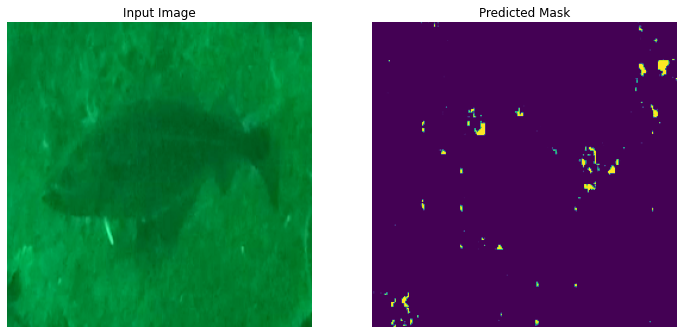

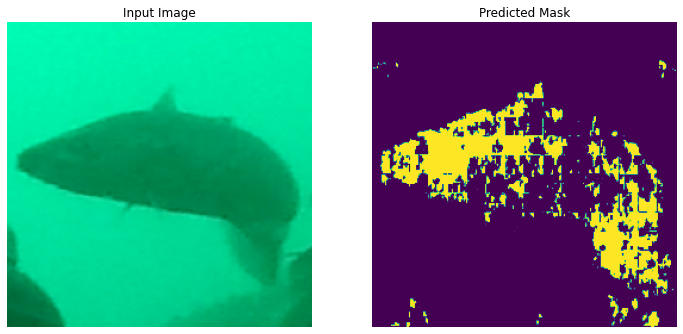

In [19]:
nf_dataset = create_dataset(nf_df, train = False)

for i in range(5):
    for images, masks in nf_dataset.take(i):        
        pred_mask = model.predict(images[tf.newaxis, ...])
        pred_mask = pred_mask.reshape(img_size[0],img_size[1],1)
        visualize([images, pred_mask])